In [1]:
import torch
import torch.nn as nn
import numpy as np


class Block(nn.Module):
    """Simple Block for the vitruvian model"""
    def __init__(self, in_planes: int, out_planes: int, drop, BN, activation):
        super(Block, self).__init__()
        features = [nn.Linear(in_planes, out_planes)]
        if BN:
            features += [nn.BatchNorm1d(out_planes)]
        if activation is not None:
            if activation.__name__ == 'ReLU':
                features += [activation(inplace=True)]
            else:
                features += [activation()]
        if drop:
            features += [nn.Dropout(0.2)]
        self.features = nn.Sequential(*features)

    def forward(self, x):
        x = self.features(x)
        return x


class LinearModel(nn.Module):
    """Linear Model for the vitruvian block"""
    def __init__(self, in_planes: int, out_planes: int, linear_size, drop: bool = False,
                 bn: bool = False, residual: bool = True, activation=nn.ReLU,
                 attention: bool = False, bigskip: bool = False):
        super(LinearModel, self).__init__()
        self.residual = residual
        self.attention = attention
        self.bigskip = bigskip
        self.inputBlock = nn.Sequential(*[Block(in_planes, linear_size, drop, bn, activation)])
        self.Block1 = nn.Sequential(*[Block(linear_size, linear_size, drop, bn, activation),
                                      Block(linear_size, linear_size, drop, bn, activation)])
        self.Block2 = nn.Sequential(*[Block(linear_size, linear_size, drop, bn, activation),
                                      Block(linear_size, linear_size, drop, bn, activation)])
        self.outputBlock = nn.Sequential(*[Block(linear_size, out_planes, False, False, None)])

        if self.attention:
            self.attentionBlock = nn.Sequential(*[Block(linear_size, out_planes, False, False, nn.Sigmoid)])

        if self.bigskip:
            self.skipBlock = nn.Sequential(*[Block(out_planes * 2, out_planes * 2, drop, bn, activation),
                                             Block(out_planes * 2, out_planes, False, False, None)])

    def forward(self, x):
        size = x.size()[1:]
        n_features = np.prod(size)
        x = x.view(-1, n_features)

        inp = x

        x = self.inputBlock(x)

        if self.attention:
            attention = self.attentionBlock(x)

        residual = x
        x = self.Block1(x)
        x = x + residual if self.residual else x

        residual = x
        x = self.Block2(x)
        x = x + residual if self.residual else x

        x = self.outputBlock(x)

        if self.bigskip:
            x = self.skipBlock(torch.cat((x, inp), dim=1))

        if self.attention:
            x = attention * x

        x = x.view(-1, size[0], size[1])
        return x

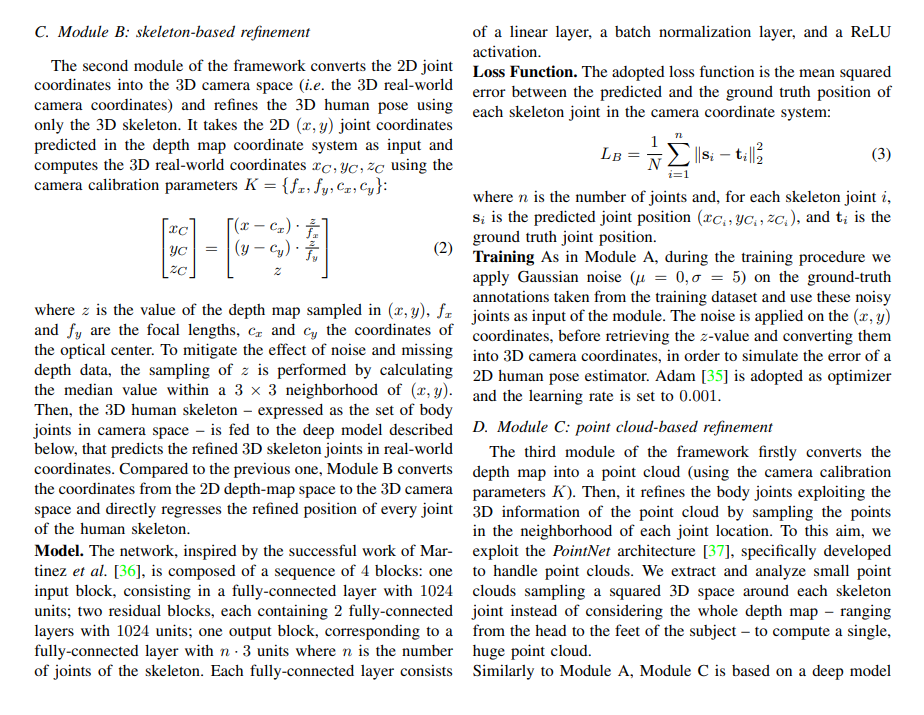

In [3]:
in_planes = 15*3
n_joints = 15  # For example, if you have 15 joints
out_planes = n_joints * 3  # Each joint has 3 coordinates (x, y, z)

# Create the model instance
linear_size = 1024
model = LinearModel(in_planes=in_planes, out_planes=out_planes, linear_size=linear_size, drop=True, bn=True)

# Load the weights from the file, mapping storage to the CPU
checkpoint = torch.load('mod_B.pth', map_location=torch.device('cpu'))

# Remove 'module.' prefix if the model was trained with DataParallel
state_dict = checkpoint['state_dict']
new_state_dict = {}
for k, v in state_dict.items():
    name = k.replace('module.', '')  # remove 'module.' prefix
    new_state_dict[name] = v

# Load the weights into the model
model.load_state_dict(new_state_dict)

<ipython-input-3-255b1dd3f902>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('mod_B.pth', map_location=torch.device('cpu'))


<All keys matched successfully>

In [4]:
print(model)

LinearModel(
  (inputBlock): Sequential(
    (0): Block(
      (features): Sequential(
        (0): Linear(in_features=45, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (Block1): Sequential(
    (0): Block(
      (features): Sequential(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (1): Block(
      (features): Sequential(
        (0): Linear(in_features=1024, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (Block2): Sequential(
    (0): Bl

In [ ]:
'''[[0.034393310546875, -2.9340625, 0.5205078125],
[0.01224517822265625, -2.934609375, 0.262939453125],
[-0.16064453125, -2.946328125, 0.271484375],
[0.1851806640625, -2.9309375, 0.254638671875],
[-0.31689453125, -2.93046875, 0.07080078125],
[0.378662109375, -2.944140625, 0.034912109375],
[-0.42431640625, -2.942734375, -0.236041259765625],
[0.41552734375, -2.932578125, -0.2336181640625],
 [0.0016345977783203125, -2.946328125, 0.023590087890625],
 [-0.11883544921875, -2.9578125, -0.2105712890625],
[0.10089111328125, -2.9421875, -0.22119140625],
[-0.487216796875, -2.90121875, -0.55509765625],
[0.11370849609375, -2.831484375, -0.74658203125],
[-0.790390625, -2.930859375, -0.851875],
[0.069091796875, -2.930859375, -1.1943359375]]}'''

In [5]:
# Set the model to evaluation mode to bypass batch normalization issues in training mode
model.eval()

# Input data
input_data = [[0.034393310546875, -2.9340625, 0.5205078125],
              [0.01224517822265625, -2.934609375, 0.262939453125],
              [-0.16064453125, -2.946328125, 0.271484375],
              [0.1851806640625, -2.9309375, 0.254638671875],
              [-0.31689453125, -2.93046875, 0.07080078125],
              [0.378662109375, -2.944140625, 0.034912109375],
              [-0.42431640625, -2.942734375, -0.236041259765625],
              [0.41552734375, -2.932578125, -0.2336181640625],
              [0.0016345977783203125, -2.946328125, 0.023590087890625],
              [-0.11883544921875, -2.9578125, -0.2105712890625],
              [0.10089111328125, -2.9421875, -0.22119140625],
              [-0.487216796875, -2.90121875, -0.55509765625],
              [0.11370849609375, -2.831484375, -0.74658203125],
              [-0.790390625, -2.930859375, -0.851875],
              [0.069091796875, -2.930859375, -1.1943359375]]

# Convert input data to a torch tensor and reshape it for the model
input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0)

# Forward pass through the model with evaluation mode
with torch.no_grad():
    output = model(input_tensor)

# Print the output result
print(output.detach().numpy())


[[[ -124.381775  -724.11194   5308.718   ]
  [ -123.47682   -982.2994    5504.141   ]
  [ -305.20065   -967.4575    5491.155   ]
  [   54.284534 -1001.196     5452.727   ]
  [ -361.40012  -1125.5609    5607.9526  ]
  [  144.99628  -1290.9124    5450.5195  ]
  [ -421.9109   -1459.4624    5622.3555  ]
  [  202.61928  -1534.1587    5273.465   ]
  [ -118.040886 -1260.6595    5651.627   ]
  [ -234.14032  -1528.0775    5777.313   ]
  [  -16.399908 -1548.4907    5738.536   ]
  [ -229.96742  -2136.9392    5458.0835  ]
  [  133.01085  -2097.7188    5341.242   ]
  [ -251.43481  -2586.5144    5900.855   ]
  [ -102.51067  -2466.4102    5724.901   ]]]
